# Homwork 1

## 1. Stereo Reconstruction and laser-pattern

1.1 Read the color, infrared1, infrared2 images in the folder Homework/HW-1-data (images with numbers (1262, 1755, 1131, 0000))

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Read images from the specified directory
def read_images(config):
    images = []
    for suffix in config['prefixes']:
        for num in config['numbers']:
            path = f"{config['root']}/{suffix}{num}.jpg"
            print(f"Reading {path}...")
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE if 'infra1_' or 'infra2_' in suffix else cv2.IMREAD_COLOR)
            if img is not None:
                images.append(img)
            else:
                print(f"Warning: {path} could not be loaded.")
    return images

1.2 Use OpenCV Stereo Block Matching to find the disparity map, then use the equation for depth to calculate the estimated depth map. You could assume that (focal_length=970 mm, baseline=50 mm) 

In [4]:
def compute_depth_map(infrared1, infrared2, config):
    stereo = cv2.StereoBM_create(config['numDisparities'], config['blockSize'])
    disparity = stereo.compute(infrared1, infrared2)
    depth = (config['focal_length_mm'] * config['baseline_mm']) / (disparity + 1e-6)
    return depth

1.3 Use OpenCV to visualize the reconstructed depth image along with the infrared images using `cv2.imshow`.

In [6]:
config= {
    'root': './HW1-1-data',
    'prefixes': ['infra1_', 'infra2_'],
    'numbers': ['1262', '1755', '1131', '0000'],
    'numDisparities': 48,
    'blockSize': 25,
    'focal_length_mm': 970,
    'baseline_mm': 50,
    'save_path': './outputs'
}

In [7]:
# Create save folder if it doesn't exist
save_folder = config['save_path']
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print(f"Folder '{save_folder}' created.")

# Compute depth maps
images = read_images(config)
depth_map = [compute_depth_map(images[i],images[i+4],config) for i in range(len(images)//2)]

# Display depth maps
for img,number in zip(depth_map,config['numbers']):
    window_name = f"depth_{number}"
    cv2.imshow(window_name, img)

while True:
    k = cv2.waitKey(0)  # 0 makes waitKey wait indefinitely for a key press
    if k != -1:  # If a key was pressed
        print("Key pressed. Exiting...")
        break
cv2.destroyAllWindows()

Reading ./HW1-1-data/infra1_1262.jpg...
Reading ./HW1-1-data/infra1_1755.jpg...
Reading ./HW1-1-data/infra1_1131.jpg...
Reading ./HW1-1-data/infra1_0000.jpg...
Reading ./HW1-1-data/infra2_1262.jpg...
Reading ./HW1-1-data/infra2_1755.jpg...
Reading ./HW1-1-data/infra2_1131.jpg...
Reading ./HW1-1-data/infra2_0000.jpg...
Key pressed. Exiting...


 1.4 Depth Quality Differences
 

1.4.1 Planes with Texture (Checkerboard) vs. Planes Without Texture (the PC case)

- **Texture:** 
  - Textured surfaces provide more distinct visual features for depth estimation and allow for better disparity calculation. This results in clear and more defined boundaries around the texture area.

- **Textureless:** 
  - These surfaces lack distinctive features, making it harder to accurately calculate depth and resulting in less precise or noisy depth data.

1.4.2 With Laser Pattern (1262, 1755) vs No Laser Pattern (0000, 1131)

- **With Laser Pattern:** 
  - Provides distinct features even in the textureless areas and thus has more precise and better depth estimation.

- **No Laser Pattern:** 
  - The quality is much lower. The depth maps are more noisy and less accurate.


    
        

TypeError: 'pyrealsense2.pyrealsense2.config' object is not subscriptable

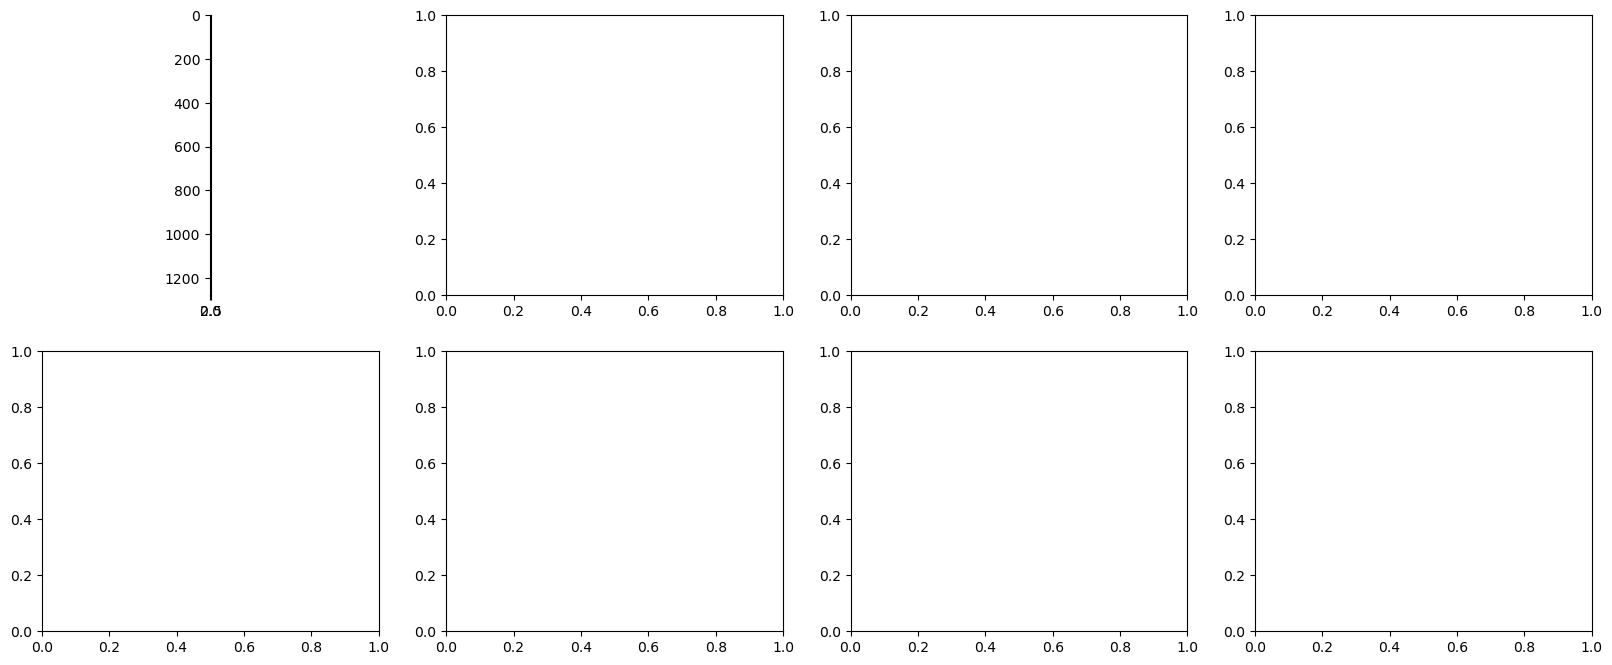

In [32]:
# Optional: Display depth maps using matplotlib
fig, axs = plt.subplots(2, len(depth_map), figsize=(20,8))
# show the original infra1 images in the first row
for i in range(len(images)//2):
    axs[0,i].imshow(images[i], cmap='gray')
    axs[0,i].set_title(f"infra1_{config['numbers'][i]}")
    axs[0, i].axis('off')  # Turn off the axis


for i in range(len(depth_map)):
    filename = mpimg.imread(f"outputs/depth_{config['numbers'][i]}.png")
    axs[1,i].imshow(filename, cmap='gray')
    axs[1,i].set_title(f"depth_{config['numbers'][i]}")
    axs[1, i].axis('off')  # Turn off the axis

### 2. Object Twin (workload 3 students):
In this exercise, we will load a realsense-viewer rosbag recording, then use opencv and pyrender to create a twin of a moving checkerboard.
1. Loading color and depth data:
     * Use pyrealsense2 to read the bagfile and acquire color, depth, aligned depth to color, color camera intrinsics, depth camera intrinsics. (Show the images in a loop using `cv2.imshow`)

In [31]:
import pyrealsense2 as rs
import numpy as np
import cv2

# Setup:
bag_path = "./HW1-2-data/20220405_220626.bag"  # Update this to the path of your .bag file

# Create a pipeline
pipeline = rs.pipeline()

# Create a config object and configure the pipeline to stream
config = rs.config()

# Tell config that we will use a recorded device from file to be used by the pipeline through playback.
config.enable_device_from_file(bag_path, repeat_playback=False)

# Configure the pipeline to stream the color and depth streams
config.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.rgb8, 30)

# Start streaming from file
profile = pipeline.start(config)

# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)

instrinsics_flag = True

try:
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        
        # Align the depth frame to color frame
        aligned_frames = align.process(frames)
        
        # Get aligned frames
        aligned_depth_frame = aligned_frames.get_depth_frame()  # aligned depth frame
        color_frame = aligned_frames.get_color_frame()          # color frame

        # Validate that both frames are valid
        if not aligned_depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        if instrinsics_flag:
            instrinsics_flag = False
            color_intrinsics = color_frame.profile.as_video_stream_profile().intrinsics
            depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
            # Print camera intrinsics
            print("Color Camera Intrinsics:")
            print(color_intrinsics)
            print("Depth Camera Intrinsics:")
            print(depth_intrinsics)

        # Convert the color image from RGB to BGR (OpenCV uses BGR)
        color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)

        # Render images:
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.09), cv2.COLORMAP_JET)
        images = np.hstack((color_image, depth_colormap))

        cv2.imshow('RealSense', images)
        
        # Press 'q' to close the window
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    # Stop streaming
    pipeline.stop()
    cv2.destroyAllWindows()


Color Camera Intrinsics:
[ 640x480  p[323.426 249.374]  f[607.323 606.302]  Inverse Brown Conrady [0 0 0 0 0] ]
Depth Camera Intrinsics:
[ 640x480  p[323.426 249.374]  f[607.323 606.302]  Inverse Brown Conrady [0 0 0 0 0] ]
